This notebook shows how to use and test the script I made for converting sbml files to stan files.

## How to run the sbml-to-stan script
First let's check that there is an appropriate sbml file at the relative path `../data_in/t_brucei.xml`

In [1]:
!head -10 ../data_in/t_brucei.xml

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by COPASI version 4.24 (Build 197) on 2019-03-31 22:10 with libSBML version 5.17.0. -->
<sbml xmlns="http://www.sbml.org/sbml/level2/version4" level="2" version="4">
  <model metaid="COPASI0" id="Bakker2001_Glycolysis" name="Bakker2001_Glycolysis">
    <notes>
      <body xmlns="http://www.w3.org/1999/xhtml">
        <p align="right">
          <font color="#FFFFFF">.</font>
        </p>
        <p align="right">


It looks like that file exists and contains the string 'SBML'! Now we can run the script:

In [2]:
%run convert_sbml_to_stan.py --input_file ../data_in/t_brucei.xml

Parsing sbml input...
Converting parsed sbml to Stan...
Writing Stan code to /Users/tedgro/Code/ecoli_stan/python/../stan/autogen/t_brucei.stan...
Finished!


## Quickly sanity checking the output

It (says that it) worked! Let's have a quick look at the output to see if it looks like it should:

In [3]:
!head -10 ../stan/autogen/t_brucei.stan
print('...')
!tail -42 ../stan/autogen/t_brucei.stan

real Function_for_Glucose_transport(real GlcE,real GlcI,real K1Glc,real Vm1,real Vt,real afac,real tot_cell){
  return tot_cell / Vt * Vm1 * (GlcE - GlcI) / (K1Glc + GlcE + GlcI + afac * GlcE * GlcI / K1Glc);
}

real Function_for_Hexokinase(real ADPg,real ATPg,real Glc6P,real GlcI,real K2ADPg,real K2ATPg,real K2Glc6P,real K2GlcI,real Vm2,real Vt,real tot_cell){
  return tot_cell / Vt * Vm2 * GlcI * ATPg / (K2ATPg * K2GlcI * (1 + Glc6P / K2Glc6P + GlcI / K2GlcI) * (1 + ATPg / K2ATPg + ADPg / K2ADPg));
}

real Function_for_Glucose_phosphate_isomerase(real Fru6P,real Glc6P,real K3Fru6P,real K3Glc6P,real Vm3,real Vt,real glycosome,real tot_cell){
  return tot_cell / Vt * Vm3 * (Glc6P / K3Glc6P - Fru6P / K3Fru6P) / (1 + Glc6P / K3Glc6P + Fru6P / K3Fru6P) / glycosome;
...
  real vGlyK = Function_for_Glycerol_kinase(ADPg, ATPg, Gly, Gly3Pg, K14ADPg, K14ATPg, K14Gly, K14Gly3Pg, Vm14, Vm14f, Vm14r, Vt, tot_cell);
  return [vGlcTr, vHK, vPGI, vPFK, vALD, vTPI, vGAPdh, vGDH, vGPO, vPyrTr, vPGK, v

This looks roughly correct: at the top of the file there are some functions for finding reaction rates given parameters, and at the bottom there is a function calcluating rates of change of some metabolites, and most importantly a `steady_state_equation` function with the right functional form to use in Stan's equation solver.

# Generating a time course with the auto-generated Stan code

One way to test if the Stan code really copies the sbml file is to run a time course and compare the output with some numbers generated independently from the same sbml.

The required time course can be generated using the following Stan model:

In [4]:
!cat ../stan/timecourse_model_template.stan

functions {
#include REPLACE_THIS_WORD
  real[] ode(real t,        // time
             real[] s,      // state
             real[] theta,  // parameters
             real[] x_r,    // data (real)
             int[] x_i){   // data (integer)
    return to_array_1d(steady_state_equation(to_vector(s), to_vector(theta), x_r, x_i));
  }
}
data {
  int<lower=1> N_ode;
  int<lower=1> N_derived;
  int<lower=1> N_known_real;
  int<lower=1> P;
  int<lower=1> T;
  real initial_metabolite_ode[N_ode];
  real kinetic_parameters[P];
  real known_reals[N_known_real];
  real ts[T];
  real t0;
  real rel_tol;
  real abs_tol;
  int max_num_steps;
}
generated quantities {
  int known_ints[0];
  real ode_metabolite_sim[T+1,N_ode]; 
  real derived_quantity_sim[T+1, N_derived];
  ode_metabolite_sim[1] = initial_metabolite_ode;
  ode_metabolite_sim[2:T+1] = integrate_ode_bdf(ode,
                                                initial_metabolite_ode,
                                                t0,
      

The python script below replaces the word `REPLACE_THIS_WORD` above with the relative path to `t_brucei.stan`, then compiles the model and runs it using the initial concentrations and parameter values from `t_brucei.xml`. The results are written to `data_out/timecourse_t_brucei.csv`.

In [5]:
#!python empty_stan_cache.py

In [6]:
!python run_timecourse.py

N_ode <- 13
N_derived <- 13
N_known_real <- 17
P <- 60
T <- 100
initial_metabolite_ode <-
c(0.0340009, 7.63936, 2.07199, 0.511773, 16.5371, 3.89921, 0.0399329, 3.95514, 0.0326745, 0.0448639, 4.77413, 1.59603, 6.51839)
kinetic_parameters <-
c(2.0, 106.2, 0.75, 0.126, 0.116, 12.0, 0.1, 625.0, 0.12, 0.4, 848.0, 0.026, 0.82, 15.8, 10.7, 780.0, 0.015, 0.067, 0.098, 184.5, 219.555, 1.2, 0.25, 842.0, 0.1, 0.15, 0.45, 0.02, 1.0, 1470.0, 984.9, 0.1, 2.0, 0.4, 0.01, 1.0, 533.0, 149.24, 1.7, 368.0, 1.96, 200.0, 0.1, 0.29, 0.05, 1.62, 1.0, 640.0, 18.56, 0.114, 2600.0, 2.5, 50.0, 0.12, 0.19, 0.12, 5.1, 1.0, 200.0, 33400.0)
known_reals <-
c(5.7, 0.2446, 5.4554, 1.0, 5.7, 1.0, 3.9, 6.0, 0.442, 1.0, 45.0, 5.0, 0.187, 6.7, 0.0, 0.0, 5.0)
ts <-
c(0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.17500000000000002, 0.18, 0.185, 0.19, 0

In [7]:
import pandas as pd

timecourse = pd.read_csv('../data_out/timecourse_t_brucei.csv')

timecourse.head()

,sim_time,BPGA13,DHAP,Fru16BP,Fru6P,GAP,Glc6P,GlcI,NAD,NADH,...,ATPg,DHAPc,DHAPg,Gly3P,Gly3Pc,Gly3Pg,PEPc,PGAg,Vc,Vg
0,0.000,0.032675,3.89921,16.5371,0.511773,0.039933,2.07199,0.034001,3.95514,0.044864,...,2.61685,4.01534,1.30906,0.956179,0.984657,0.321012,0.840863,0.671134,5.4554,0.2446
1,0.005,0.032614,3.89918,16.5370,0.511777,0.039922,2.07201,0.034000,3.95512,0.044886,...,2.61720,4.01532,1.30882,0.956200,0.984682,0.320963,0.833938,0.665606,5.4554,0.2446
2,0.010,0.032565,3.89911,16.5365,0.511787,0.039911,2.07207,0.033994,3.95510,0.044902,...,2.61793,4.01526,1.30853,0.956256,0.984742,0.320917,0.828386,0.661175,5.4554,0.2446
3,0.015,0.032527,3.89902,16.5359,0.511795,0.039901,2.07212,0.033986,3.95509,0.044913,...,2.61888,4.01518,1.30827,0.956332,0.984823,0.320885,0.823912,0.657604,5.4554,0.2446
4,0.020,0.032497,3.89892,16.5351,0.511798,0.039892,2.07216,0.033976,3.95508,0.044921,...,2.61995,4.01508,1.30804,0.956420,0.984916,0.320866,0.820291,0.654714,5.4554,0.2446


The time course produced some numbers!

The rest of the notebook does some checks against correct values generated with copasi (stored at `data_out/timecourse_t_brucei_copasi.txt`) to see what might be going wrong.


## Comparing initial values with copasi

The first check is to see if the the initial concentrations from copasi agree with the first step of the Stan timecourse.

In [8]:
timecourse_copasi = pd.read_csv('../data_out/timecourse_t_brucei_copasi.txt', sep='\t')
initial_values_copasi = timecourse_copasi.iloc[0]
initial_values = timecourse.iloc[0]
initial_values

sim_time     0.000000
BPGA13       0.032675
DHAP         3.899210
Fru16BP     16.537100
Fru6P        0.511773
GAP          0.039933
Glc6P        2.071990
GlcI         0.034001
NAD          3.955140
NADH         0.044864
Nb           1.596030
Pc           6.518390
Pg           7.639360
Pyr          4.774130
ADPc         0.977038
ADPg         2.405660
ATPc         2.770680
ATPg         2.616850
DHAPc        4.015340
DHAPg        1.309060
Gly3P        0.956179
Gly3Pc       0.984657
Gly3Pg       0.321012
PEPc         0.840863
PGAg         0.671134
Vc           5.455400
Vg           0.244600
Name: 0, dtype: float64

In [9]:
print(initial_values_copasi.sort_values())
print(initial_values.sort_values())

# Time                         0.000000
bisphosphoglycerate13          0.032675
Glucose                        0.034001
Glyceraldehyde 3-phosphate     0.039933
NADH                           0.044864
Values[Vg]                     0.244600
Gy3P g                         0.321012
Fructose 6-phosphate           0.511773
PGA3 g                         0.671134
PEP c                          0.840863
Glycerol 3-phosphate           0.956179
ADP cyt                        0.977038
Gy3P c                         0.984657
DHAP gly                       1.309060
PGA3 PGA2 PEP                  1.596030
Glucose 6-phosphate            2.071990
ADP gly                        2.405660
ATP gly                        2.616850
ATP cyt                        2.770680
Dihydroxyacetone phosphate     3.899210
NAD                            3.955140
DHAP cyt                       4.015340
Pyruvate                       4.774130
Values[Vc]                     5.455400
Phosphates cytosol             6.518390


The values that appear in both serieses all seem to be correct. Now let's check the final values.

In [10]:
final_values_copasi = timecourse_copasi.iloc[-1]
final_values = timecourse.iloc[-1]

print(final_values_copasi.sort_values())
print(final_values.sort_values())

bisphosphoglycerate13          0.032411
Glucose                        0.033741
Glyceraldehyde 3-phosphate     0.039826
NADH                           0.044904
Values[Vg]                     0.244600
Gy3P g                         0.320743
# Time                         0.500000
Fructose 6-phosphate           0.511161
PGA3 g                         0.640014
PEP c                          0.801873
Glycerol 3-phosphate           0.957312
ADP cyt                        0.976737
Gy3P c                         0.985853
DHAP gly                       1.305990
PGA3 PGA2 PEP                  1.522020
Glucose 6-phosphate            2.069620
ADP gly                        2.397070
ATP gly                        2.641460
ATP cyt                        2.771090
Dihydroxyacetone phosphate     3.897930
NAD                            3.955100
DHAP cyt                       4.014150
Pyruvate                       4.816030
Values[Vc]                     5.455400
Phosphates cytosol             6.518920


These are the same two: we are looking good!

As a final check, the next cell plots a timecourse from Copasi and from Stan.

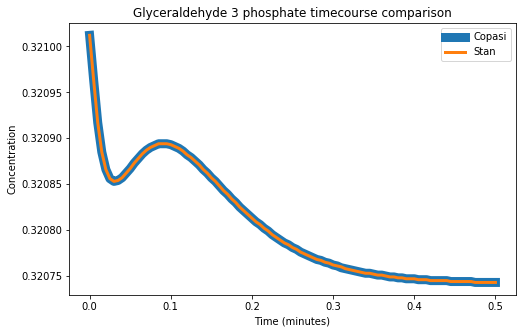

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=[8, 5])

plot_cps = ax.plot(timecourse_copasi['# Time'],
                   timecourse_copasi['Gy3P g'],
                   linewidth=9,
                   label='Copasi')
plot_stn = ax.plot(timecourse['sim_time'],
                   timecourse['Gly3Pg'],
                   linewidth=3,
                   label='Stan')
legend = ax.legend()

text = ax.set(title='Glyceraldehyde 3 phosphate timecourse comparison',
              xlabel='Time (minutes)',
              ylabel='Concentration')